# Parameter Tuning in Gradient Boosting (GBM) in Python 
Author: Thomas Spycher, March 3rd, 2018


GBM is a highly popular prediction model among data scientists or as top Kaggler Owen Zhang describes it: "My confession: I (over)use GBM. When in doubt, use GBM."

GradientBoostingClassifier from sklearn is a popular and user friendly application of Gradient Boosting in Python (another nice and even faster tool is xgboost). Apart from setting up the feature space and fitting the model, parameter tuning is a crucial task in finding the model with the highest predictive power. The code provides an example on how to tune parameters in a gradient boosting model for classification. I use a spam email dataset from the HP Lab to predict if an email is spam. The dataset contains 4601 email items, of which 1813 items were identified as spam. For a formal discussion of Gradient Boosting see [here](https://en.wikipedia.org/wiki/Gradient_boosting) and the papers mentioned in the article. The tuning process is based on recommendations by [Owen Zhang](https://nycdatascience.com/blog/meetup/featured-talk-1-kaggle-data-scientist-owen-zhang/) as well as suggestions on [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).



In [2]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


## Load dataset and split into test and train set
I use the spam dataset from HP labs via GitHub. The example will focus on tuning the parameters. Feature creating has proven to be highly effective in improving the performance of models. For simplicity, here I use only the given features and simple interactions. The dataset contains the following features:


<dl>
<dt>crl.tot</dt><dd><p>total length of words in capitals</p>
</dd>
<dt>dollar</dt><dd><p>number of occurrences of the \$ symbol</p>
</dd>
<dt>bang</dt><dd><p>number of occurrences of the ! symbol</p>
</dd>
<dt>money</dt><dd><p>number of occurrences of the word &lsquo;money&rsquo;</p>
</dd>
<dt>n000</dt><dd><p>number of occurrences of the string &lsquo;000&rsquo;</p>
</dd>
<dt>make</dt><dd><p>number of occurrences of the word &lsquo;make&rsquo;</p>
</dd>
<dt>yesno</dt><dd><p>outcome variable, a factor with levels
<code>n</code> not spam,
<code>y</code> spam</p>
</dd>
</dl>

### Importing dataset and summary statistics

In [3]:
ds=pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')
ds['spam'] = ds['yesno'].map({'y': 1, 'n': 0})
ds = ds.drop(['Unnamed: 0','yesno',], axis=1)

ds.head()



,crl.tot,dollar,bang,money,n000,make,spam
0,278,0.000,0.778,0.00,0.00,0.00,1
1,1028,0.180,0.372,0.43,0.43,0.21,1
2,2259,0.184,0.276,0.06,1.16,0.06,1
3,191,0.000,0.137,0.00,0.00,0.00,1
4,191,0.000,0.135,0.00,0.00,0.00,1


In [4]:
ds.mean()


crl.tot    283.289285
dollar       0.075811
bang         0.269071
money        0.094269
n000         0.101645
make         0.104553
spam         0.394045
dtype: float64

The descriptive statistics below give a first idea on which features are correlated with spam emails. Everything related to money (dollar, money, n000) is strongly correlated with spam. Spammers use more words in capitals and the word "make" as well as exclamation points more frequently.

In [6]:
ds.groupby(['spam']).mean()


,crl.tot,dollar,bang,money,n000,make
spam,,,,,,
0,161.470947,0.011648,0.109984,0.017138,0.007088,0.073479
1,470.619415,0.174478,0.513713,0.212879,0.247055,0.152339


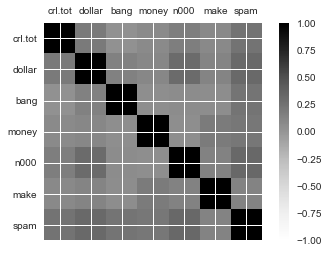

,crl.tot,dollar,bang,money,n000,make,spam
crl.tot,1.000000,0.201948,0.036321,0.080993,0.165977,0.089165,0.249164
dollar,0.201948,1.000000,0.142913,0.104691,0.310971,0.117419,0.323629
bang,0.036321,0.142913,1.000000,0.051076,0.070103,0.058292,0.241888
money,0.080993,0.104691,0.051076,1.000000,0.052587,0.188155,0.216111
n000,0.165977,0.310971,0.070103,0.052587,1.000000,0.134072,0.334787
make,0.089165,0.117419,0.058292,0.188155,0.134072,1.000000,0.126208
spam,0.249164,0.323629,0.241888,0.216111,0.334787,0.126208,1.000000


In [7]:
correlations = ds.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(ds)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations

### Set Y and X space, generate interaction terms, split dataset in train and test
We expand the feature space by creating interaction terms. (Patsy is a great scikit-learn tool to create many interaction terms with one line of code) 

In [8]:
y =ds.spam
df= ds.loc[:, ds.columns != 'spam']



In [9]:
#add features by generating interaction terms
dollar_bang=df['dollar']*df['bang']
dollar_money=df['dollar']*df['money']
dollar_n000=df['dollar']*df['n000']
dollar_make=df['dollar']*df['make']
dollar_crl=df['dollar']*df['crl.tot']

bang_money=df['bang']*df['money']
bang_n000=df['bang']*df['n000']
bang_make=df['bang']*df['make']
bang_crl=df['bang']*df['crl.tot']

money_n000=df['money']*df['n000']
money_make=df['money']*df['make']
money_crl=df['money']*df['crl.tot']

n000_make=df['n000']*df['make']
n000_crl=df['n000']*df['crl.tot']

make_crl=df['make']*df['crl.tot']

In [10]:
df=df.assign(dollar_bank=dollar_bang,dollar_money=dollar_money,dollar_n000=dollar_n000,dollar_make=dollar_make,dollar_crl=dollar_crl,bang_money=bang_money, bang_n000=bang_n000,bang_make=bang_make,bang_crl=bang_crl,money_n000=money_n000,money_make=money_make,money_crl=money_crl,n000_make=n000_make,n000_crl=n000_crl,make_crl=make_crl)
             

In [12]:
df.head()

,crl.tot,dollar,bang,money,n000,make,bang_crl,bang_make,bang_money,bang_n000,...,dollar_crl,dollar_make,dollar_money,dollar_n000,make_crl,money_crl,money_make,money_n000,n000_crl,n000_make
0,278,0.000,0.778,0.00,0.00,0.00,216.284,0.00000,0.00000,0.00000,...,0.000,0.00000,0.00000,0.00000,0.00,0.00,0.0000,0.0000,0.00,0.0000
1,1028,0.180,0.372,0.43,0.43,0.21,382.416,0.07812,0.15996,0.15996,...,185.040,0.03780,0.07740,0.07740,215.88,442.04,0.0903,0.1849,442.04,0.0903
2,2259,0.184,0.276,0.06,1.16,0.06,623.484,0.01656,0.01656,0.32016,...,415.656,0.01104,0.01104,0.21344,135.54,135.54,0.0036,0.0696,2620.44,0.0696
3,191,0.000,0.137,0.00,0.00,0.00,26.167,0.00000,0.00000,0.00000,...,0.000,0.00000,0.00000,0.00000,0.00,0.00,0.0000,0.0000,0.00,0.0000
4,191,0.000,0.135,0.00,0.00,0.00,25.785,0.00000,0.00000,0.00000,...,0.000,0.00000,0.00000,0.00000,0.00,0.00,0.0000,0.0000,0.00,0.0000


Split dataset into train and test set.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

## Run a baseline model without tuning
I use the following baseline scikit-learn library settings.<br>
#### Tree specific parameters
n_estimators=100 (number of trees) <br>
max_depth=3 <br>
min_samples_split=2 <br>
min_samples_leaf=1 <br>
subsample=1.0 <br>
#### Other Parameters
learning_rate=0.1 (shrinkage) <br>
subsample: 1 <br>


Accuracy of the GBM on test set: 0.882
             precision    recall  f1-score   support

          0       0.87      0.94      0.91       553
          1       0.90      0.79      0.84       368

avg / total       0.88      0.88      0.88       921



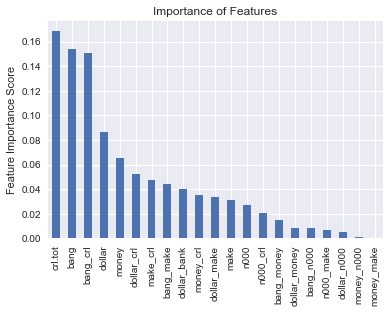

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV


baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print(classification_report(y_test, pred))

The plot displays the importance of the feature: The number of words in capital and bang seem to have the highest predictive power.

With this first model, we obtain a rate of 0.90 of true positives (positive meaning spam) and 0.87 true negatives and an accuracy of 0.88. 



## Tuning parameters
Many strategies exist on how to tune parameters. See for example this blog post on [Machine Learning Mastery](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/) for some guidance from academic papers. Most data scientist see *number of trees*, *tree depth* and *the learning rate* as most crucial parameters. 

Hence, we will start off with these three and then move to other tree-specific parameters and the subsamples. I will use 5-fold cross validation and evaluate models based on *accuracy*. You may also consider to evaluate the model based on a different measure such as *roc_auc*.


### Tunign n_estimators and Learning rate 
n_estimators captures the number of trees that we add to the model. A high number of trees can be computationally expensive. Generally, with a change in learning rate,n_estimators should also be adjusted (10-fold decrease in learning_rate should go in line with a approx. 10-fold increase in n_estimators.

In [18]:
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

([mean: 0.87500, std: 0.00909, params: {'learning_rate': 0.15, 'n_estimators': 100},
  mean: 0.87174, std: 0.01015, params: {'learning_rate': 0.15, 'n_estimators': 250},
  mean: 0.87174, std: 0.01142, params: {'learning_rate': 0.15, 'n_estimators': 500},
  mean: 0.86929, std: 0.01201, params: {'learning_rate': 0.15, 'n_estimators': 750},
  mean: 0.86712, std: 0.01368, params: {'learning_rate': 0.15, 'n_estimators': 1000},
  mean: 0.86522, std: 0.01249, params: {'learning_rate': 0.15, 'n_estimators': 1250},
  mean: 0.86413, std: 0.01269, params: {'learning_rate': 0.15, 'n_estimators': 1500},
  mean: 0.86440, std: 0.01279, params: {'learning_rate': 0.15, 'n_estimators': 1750},
  mean: 0.87826, std: 0.00809, params: {'learning_rate': 0.1, 'n_estimators': 100},
  mean: 0.87473, std: 0.00532, params: {'learning_rate': 0.1, 'n_estimators': 250},
  mean: 0.87418, std: 0.00951, params: {'learning_rate': 0.1, 'n_estimators': 500},
  mean: 0.87147, std: 0.01033, params: {'learning_rate': 0.1, 'n

### max_depth
max_depth bounds the maximum depth of the tree. We can use the obtained results to tune the max_depth parameter. There is one interesting comment on depth in the scikit-learn [documentation](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) especially relevant for large datasets: *"We found that max_leaf_nodes=k gives comparable results to max_depth=k-1 but is significantly faster to train at the expense of a slightly higher training error."*

In [19]:
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1500, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_


([mean: 0.87853, std: 0.00752, params: {'max_depth': 2},
  mean: 0.87826, std: 0.00836, params: {'max_depth': 3},
  mean: 0.87880, std: 0.00566, params: {'max_depth': 4},
  mean: 0.87826, std: 0.01026, params: {'max_depth': 5},
  mean: 0.87663, std: 0.01154, params: {'max_depth': 6},
  mean: 0.87582, std: 0.01075, params: {'max_depth': 7}],
 {'max_depth': 4},
 0.878804347826087)

## First evaluation of new model on test set
The model's performance did improve with the tuning. The "true positive" and the "true negative" rate improved. Interestingly, there was also a slight change in the ranking of feature importance with the interaction of bang and crl_tot now ranked first.

Accuracy of the GBM on test set: 0.891
             precision    recall  f1-score   support

          0       0.88      0.95      0.91       553
          1       0.92      0.80      0.85       368

avg / total       0.89      0.89      0.89       921



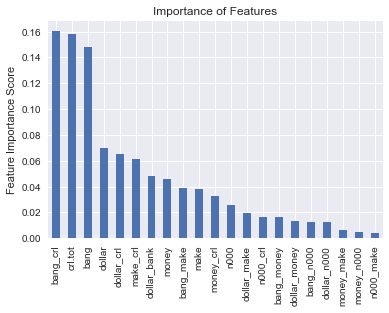

In [32]:
model1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model1.score(X_test, y_test)))
pred=model1.predict(X_test)
print(classification_report(y_test, pred))

## Other factors
### Tree related parameters

### Min sample split and min samples leaf
min_samples_split sets the minimum number of samples to split while min_samples_leaf sets the minimum number of samples to form a leaf (Notice the slight difference). 

In [22]:
p_test4 = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test4, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_


([mean: 0.87880, std: 0.00566, params: {'min_samples_leaf': 1, 'min_samples_split': 2},
  mean: 0.87880, std: 0.00579, params: {'min_samples_leaf': 1, 'min_samples_split': 4},
  mean: 0.87745, std: 0.00662, params: {'min_samples_leaf': 1, 'min_samples_split': 6},
  mean: 0.87717, std: 0.00605, params: {'min_samples_leaf': 1, 'min_samples_split': 8},
  mean: 0.87745, std: 0.00651, params: {'min_samples_leaf': 1, 'min_samples_split': 10},
  mean: 0.87690, std: 0.00635, params: {'min_samples_leaf': 1, 'min_samples_split': 20},
  mean: 0.87799, std: 0.00799, params: {'min_samples_leaf': 1, 'min_samples_split': 40},
  mean: 0.87636, std: 0.00626, params: {'min_samples_leaf': 1, 'min_samples_split': 60},
  mean: 0.87663, std: 0.00616, params: {'min_samples_leaf': 1, 'min_samples_split': 100},
  mean: 0.87772, std: 0.00783, params: {'min_samples_leaf': 3, 'min_samples_split': 2},
  mean: 0.87772, std: 0.00783, params: {'min_samples_leaf': 3, 'min_samples_split': 4},
  mean: 0.87772, std: 0.00

### Max features
The square root of features is usually a good starting point. Let's use CV to tune the parameter. 
The tuning suggests to use 4 features (close to the sqrt of 21).

In [23]:
#TUNING MAX FEATURES
p_test5 = {'max_features':[2,3,4,5,6,7]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7, subsample=1, random_state=10), 
param_grid = p_test5, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

([mean: 0.87826, std: 0.00951, params: {'max_features': 2},
  mean: 0.87962, std: 0.01004, params: {'max_features': 3},
  mean: 0.88098, std: 0.01004, params: {'max_features': 4},
  mean: 0.88043, std: 0.01028, params: {'max_features': 5},
  mean: 0.88098, std: 0.00955, params: {'max_features': 6},
  mean: 0.87935, std: 0.00939, params: {'max_features': 7}],
 {'max_features': 4},
 0.8809782608695652)

## subsample
Subsample sets the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.

In [28]:
p_test6= {'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , random_state=10), 
param_grid = p_test6, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

([mean: 0.88125, std: 0.00883, params: {'subsample': 0.7},
  mean: 0.87880, std: 0.00830, params: {'subsample': 0.75},
  mean: 0.87962, std: 0.00875, params: {'subsample': 0.8},
  mean: 0.87962, std: 0.00853, params: {'subsample': 0.85},
  mean: 0.88071, std: 0.00891, params: {'subsample': 0.9},
  mean: 0.88179, std: 0.00829, params: {'subsample': 0.95},
  mean: 0.88098, std: 0.01004, params: {'subsample': 1}],
 {'subsample': 0.95},
 0.8817934782608695)

# Evaluation of final model on Test set
The final model performs slightly worse than the model after the first stage of parameter tuning if applied to the test set. The difference is, however, very small. 

Accuracy of the GBM on test set: 0.888
             precision    recall  f1-score   support

          0       0.88      0.95      0.91       553
          1       0.91      0.80      0.85       368

avg / total       0.89      0.89      0.89       921



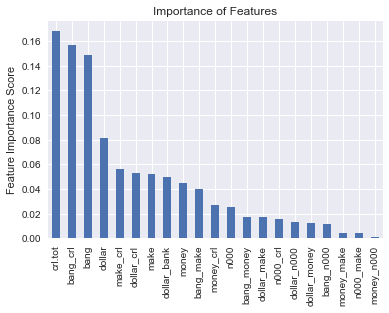

In [31]:
new=GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)
new.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(new.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(new.score(X_test, y_test)))
pred=new.predict(X_test)
print(classification_report(y_test, pred))

## Comparision of ROC AUC
Comparing the area under the curve, the three models only very slightly differ. 

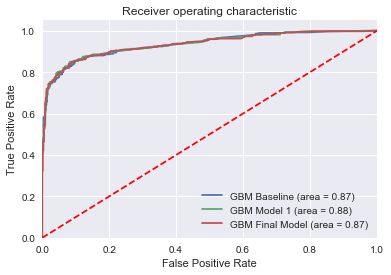

In [44]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 


#run models
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)

model1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(X_train,y_train)

new=GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)
new.fit(X_train,y_train)

#calculate values for ROC AUC plot
#baseline model
baseline_roc_auc = roc_auc_score(y_test, baseline.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, baseline.predict_proba(X_test)[:,1])
#model 1
model1_roc_auc = roc_auc_score(y_test, model1.predict(X_test))
fpr1, tpr1, thresholds1 = roc_curve(y_test, model1.predict_proba(X_test)[:,1])
#new tuned model 
new_roc_auc = roc_auc_score(y_test, new.predict(X_test))
fprnew, tprnew, thresholds_new = roc_curve(y_test, new.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fprB, tprB, label='GBM Baseline (area = %0.2f)' % baseline_roc_auc)
plt.plot(fpr1, tpr1, label='GBM Model 1 (area = %0.2f)' % model1_roc_auc)
plt.plot(fprnew, tprnew, label='GBM Final Model (area = %0.2f)' % new_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
